# Forward Modelling of a Many Lines Spectrum using MODIT

Here, we try to compute a emission spectrum using MODIT.

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import modit
from exojax.spec import lpf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

We set a wavenumber grid using nugrid. Specify xsmode="dit" though it is not mandatory.
DIT uses FFT, so the (internal) wavenumber grid should be linear. 
But, you can also use a nonlinear grid. In this case, the interpolation (jnp.interp) is used.   

In [3]:
from exojax.spec.rtransfer import nugrid
nus,wav,R=nugrid(22900,23000,10000,unit="AA",xsmode="modit")

nugrid is log: mode= modit


Loading a molecular database of CO and CIA (H2-H2)... 

In [4]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
H2-H2


In [5]:
from exojax.spec import molinfo
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [6]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [7]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]


MODIT uses the normalized gammaL.

In [8]:
dv_lines=mdbCO.nu_lines/R
ngammaLM=gammaLM/dv_lines

normalized Doppler broadening is common for the lines, so we compute the vector for the layers.

In [9]:
from exojax.spec import normalized_doppler_sigma
nsigmaDl=normalized_doppler_sigma(Tarr,molmassCO,R)[:,np.newaxis]

And line strength

In [10]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

MODIT requires the grids of ngammaL, and wavenumber. For the emission spectrum, this grids should be prepared for each layer. 
dit.dgmatrix can compute these grids.   

In [11]:
dgm_ngammaL=modit.dgmatrix(ngammaLM)
#you can change the resolution 
#dgm_gammaL=dit.dgmatrix(ngammaLM,res=0.1)

We can check how the grids are set for each layers using plot.ditplot.plot_dgm 

3


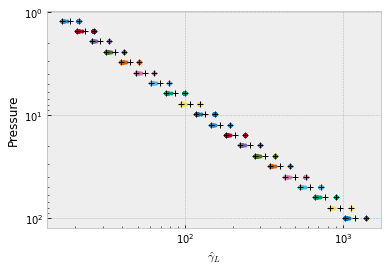

In [13]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgmn
plot_dgmn(Parr,dgm_ngammaL,ngammaLM,80,100)

Initialize modit!

In [ ]:
from exojax.spec import initspec 
cnu,indexnu,R,pmarray=initspec.init_modit(mdbCO.nu_lines,nus)

Compute the cross section array!

In [ ]:
xsmmodit=modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl,ngammaLM,SijM,nus,dgm_ngammaL)

Some elements may be small negative values because of error for DIT. you can just use jnp.abs

In [ ]:
import jax.numpy as jnp
print(len(xsmmodit[xsmmodit<0.0]),"/",len((xsmmodit).flatten()))

In [13]:
xsmmodit=jnp.abs(xsmmodit)

NameError: name 'jnp' is not defined

We also compute the cross section using the direct computation (LPF) for the comparison purpose.

In [17]:
#direct LPF for comparison

#we need sigmaDM for LPF
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)

from exojax.spec.lpf import xsmatrix
numatrix=initspec.init_lpf(mdbCO.nu_lines,nus)
xsmdirect=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

BTW, if you are not busy, check the computational time for both LPF and MODIT.

In [19]:
%timeit modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl,ngammaLM,SijM,nus,dgm_ngammaL)

10.9 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

71.9 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's see the cross section matrix!

/tmp/ipykernel_29941/2412046399.py:5: RuntimeWarning: divide by zero encountered in log10
  c=plt.imshow(np.log10(xsmmodit),cmap="bone_r",vmin=-23,vmax=-19)


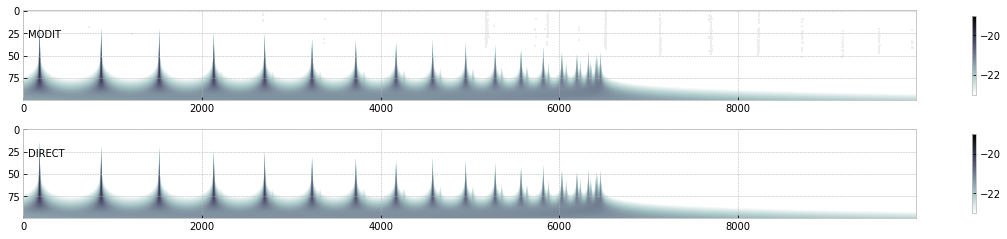

In [21]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(211)
c=plt.imshow(np.log10(xsmmodit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"MODIT")

ax.set_aspect(0.1/ax.get_data_ratio())
ax=fig.add_subplot(212)
c=plt.imshow(np.log10(xsmdirect),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIRECT")
ax.set_aspect(0.1/ax.get_data_ratio())
plt.show()

computing delta tau for CO

In [22]:
from exojax.spec.rtransfer import dtauM
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsmmodit,MMR*np.ones_like(Tarr),molmassCO,g)

In [23]:
dtaumdirect=dtauM(dParr,xsmdirect,MMR*np.ones_like(Tarr),molmassCO,g)

computing delta tau for CIA

In [24]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [25]:
dtau=dtaum+dtaucH2H2
dtaudirect=dtaumdirect+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

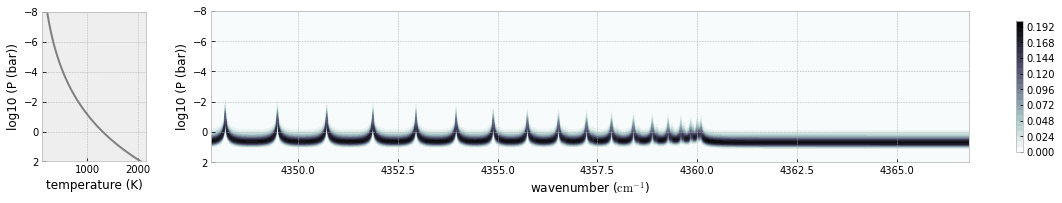

In [26]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [27]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)
F0direct=rtrun(dtaudirect,sourcef)

The difference is very small except around the edge (even for this it's only 1%).

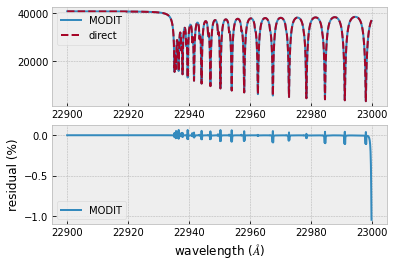

In [28]:
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,label="MODIT")
plt.plot(wav[::-1],F0direct,ls="dashed",label="direct")
plt.legend()
ax=fig.add_subplot(212)
plt.plot(wav[::-1],(F0-F0direct)/np.median(F0direct)*100,label="MODIT")
plt.legend()
#plt.ylim(-0.1,0.1)
plt.ylabel("residual (%)")
plt.xlabel("wavelength ($\AA$)")
plt.show()

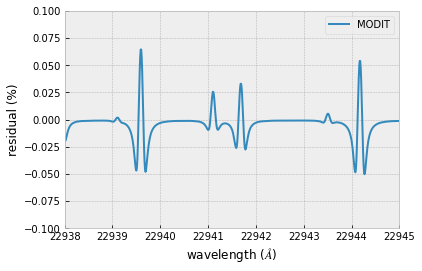

In [29]:
ax=fig.add_subplot(212)
plt.plot(wav[::-1],(F0-F0direct)/np.median(F0direct)*100,label="MODIT")
plt.legend()
plt.ylim(-0.1,0.1)
plt.xlim(22938,22945)
plt.ylabel("residual (%)")
plt.xlabel("wavelength ($\AA$)")
plt.show()

MODIT uses ESLOG as the wavenumebr grid. So, we can directly apply the response. 

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [30]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

Rinst=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*Rinst) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

(22920.0, 23000.0)

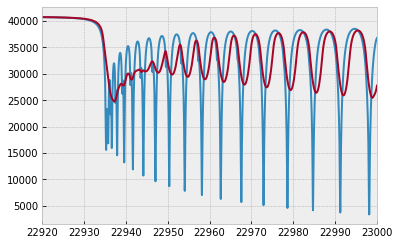

In [31]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)
plt.xlim(22920,23000)